<a href="https://colab.research.google.com/github/tvmnhajat/stock_prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
sp500_data = yf.download("^GSPC", start="2020-01-01", end="2023-03-29")
sp500_df = pd.DataFrame(sp500_data)
sp500_df.to_csv("sp500_data.csv")


[*********************100%%**********************]  1 of 1 completed


In [ ]:
read_df = pd.read_csv("sp500_data.csv")
read_df.set_index("Date", inplace=True)

read_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000


In [ ]:
read_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,815.000000,815.000000,815.000000,815.000000,815.000000,8.150000e+02
mean,3871.483433,3898.160207,3842.594587,3871.845352,3871.845352,4.637051e+09
std,532.353347,530.440256,534.574698,532.506341,532.506341,1.100917e+09
min,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,1.706460e+09
25%,3485.439941,3501.899902,3451.109985,3481.035034,3481.035034,3.939435e+09
50%,3937.600098,3968.010010,3910.860107,3939.340088,3939.340088,4.397230e+09
75%,4276.295166,4299.959961,4239.890137,4282.220215,4282.220215,5.014720e+09
max,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,9.976520e+09


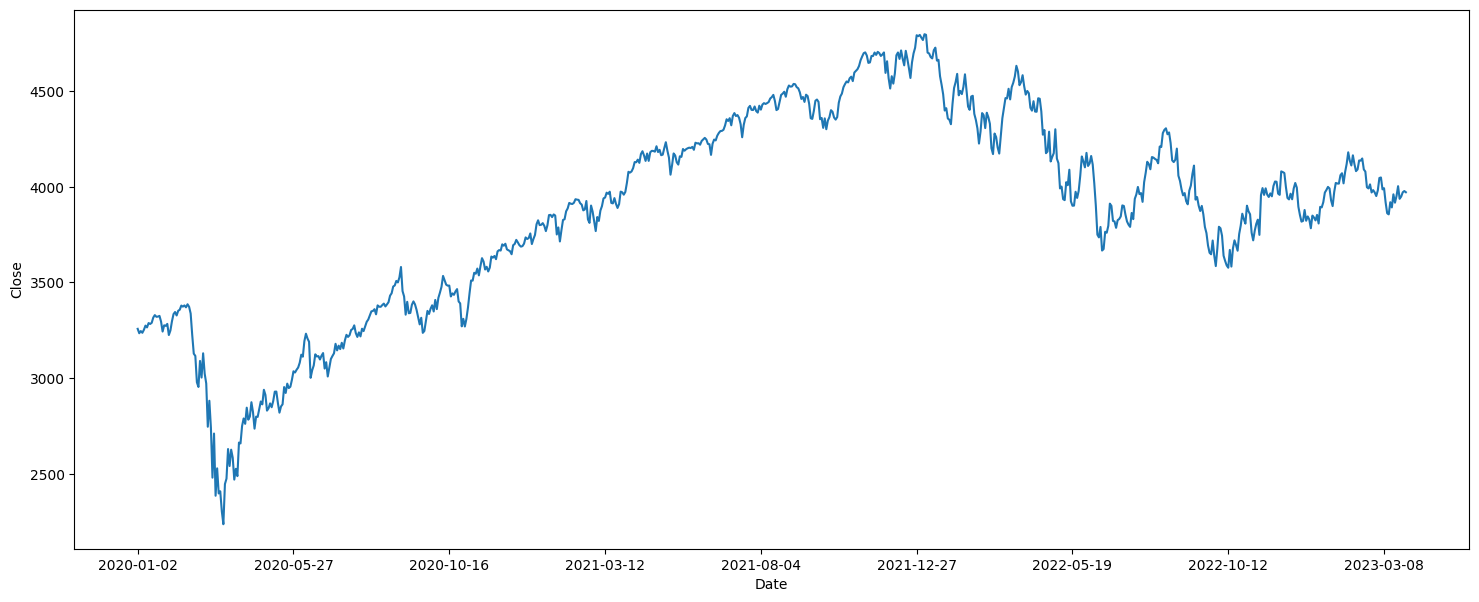

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
read_df['Adj Close'].plot()
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()

In [ ]:
read_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
read_df.interpolate()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000
...,...,...,...,...,...,...
2023-03-22,4002.040039,4039.489990,3936.169922,3936.969971,3936.969971,4533010000
2023-03-23,3959.209961,4007.659912,3919.050049,3948.719971,3948.719971,4991600000
2023-03-24,3939.209961,3972.739990,3909.159912,3970.989990,3970.989990,4583970000


In [ ]:
features = ['Open', 'High', 'Low', 'Volume']

scaler = MinMaxScaler()
X = scaler.fit_transform(read_df[features])
X = pd.DataFrame(columns=features, data=X, index=read_df.index)
X.head()

,Open,High,Low,Volume
Date,,,,
2020-01-02,0.379489,0.380243,0.403245,0.212026
2020-01-03,0.372206,0.375481,0.398149,0.215021
2020-01-06,0.368701,0.375755,0.395173,0.241353
2020-01-07,0.378371,0.374989,0.402047,0.209122
2020-01-08,0.377071,0.383790,0.403685,0.244301


In [ ]:
y = pd.DataFrame(read_df['Adj Close'])

timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X):
        X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model.fit(X_train, y_train)
predict = model.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 14.7123
Mean Squared Error: 316.455
Root Mean Squared Error: 17.7892
(R^2) Score: 0.9663
Train Score : 99.97% and Test Score : 96.63% using Random Tree Regressor.
Accuracy: 99.63 %.


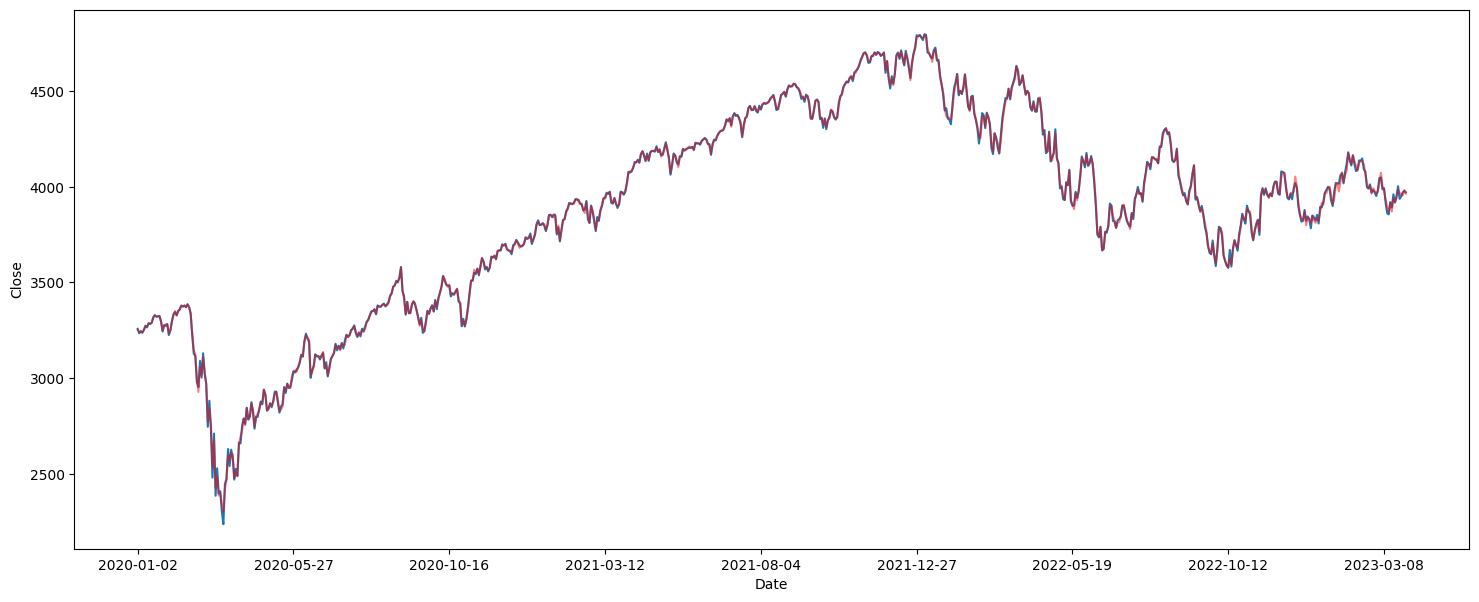

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
read_df['Adj Close'].plot(alpha=1)
ax.plot(model.predict(X), color='red', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()


In [ ]:
print(X)


                Open      High       Low    Volume
Date                                              
2020-01-02  0.379489  0.380243  0.403245  0.212026
2020-01-03  0.372206  0.375481  0.398149  0.215021
2020-01-06  0.368701  0.375755  0.395173  0.241353
2020-01-07  0.378371  0.374989  0.402047  0.209122
2020-01-08  0.377071  0.383790  0.403685  0.244301
...              ...       ...       ...       ...
2023-03-22  0.680774  0.690562  0.673952  0.341781
2023-03-23  0.663736  0.677921  0.667338  0.397233
2023-03-24  0.655780  0.664052  0.663516  0.347943
2023-03-27  0.673172  0.676400  0.687213  0.305570
2023-03-28  0.669671  0.666618  0.679887  0.279096

[815 rows x 4 columns]
